## Sentiment Analysis Using Bidirectional RNN Model with Attention Mechanism

In this project we will be using Bidirectional RNN model with attention mechanism for sentiment analysis on reviews data from Yelp reviews dataset.

First, we are importing the neccasary libraries

In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import re

In [4]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate, Dropout, Activation, Embedding, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Convolution1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers, regularizers, constraints, layers, optimizers

Now, we are loading the dataset

In [6]:
path = 'yelp_reviews.json'

In [7]:
reviews = pd.read_json(path, lines=True,
                       dtype={'review_id':str,'user_id':str,
                              'business_id':str,'stars':int,
                              'date':str,'text':str,'useful':int,
                              'funny':int,'cool':int}, nrows=200000)

The stars and text features will be the needed ones

In [8]:
reviews_df_text = reviews[['stars','text']]

In [9]:
reviews_df_text

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
1,5,I've taken a lot of spin classes over the year...
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...
...,...,...
199995,5,Oakley's Bistro is a hidden gem for Indianapol...
199996,5,"Let me just say, I'm glad my husband and I dec..."
199997,5,I was coming back from the Farmers market toda...
199998,5,Absolutely perfect meal for me. The food is cl...


We are creating a new feature "sentiment" with values 0 and 1. The reviews with above 3 stars are 1 or positive and below are 0 or negative.

In [11]:
reviews_df_text['sentiment'] = np.where(reviews_df_text['stars'] > 3, 1, 0)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4740\1477322979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df_text['sentiment'] = np.where(reviews_df_text['stars'] > 3, 1, 0)


We are creating a function to clean the text data.

In [12]:
lemmatizer = WordNetLemmatizer()

In [13]:
stop_words = set(stopwords.words("english"))

In [14]:
def text_cleaner(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    
    return text

In [15]:
reviews_df_text['processed Reviews'] = reviews_df_text.text.apply(lambda x: text_cleaner(x))

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4740\3445599890.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df_text['processed Reviews'] = reviews_df_text.text.apply(lambda x: text_cleaner(x))


**The pre-processed text reviews with corresponding sentiment values.**

In [16]:
reviews_df_text

,stars,text,sentiment,processed Reviews
0,3,"If you decide to eat here, just be aware it is...",0,decide eat aware go take 2 hour begin end try ...
1,5,I've taken a lot of spin classes over the year...,1,ive take lot spin class year nothing compare c...
2,3,Family diner. Had the buffet. Eclectic assortm...,0,family diner buffet eclectic assortment large ...
3,5,"Wow! Yummy, different, delicious. Our favo...",1,wow yummy different delicious favorite lam...
4,4,Cute interior and owner (?) gave us tour of up...,1,cute interior owner give u tour upcoming pati...
...,...,...,...,...
199995,5,Oakley's Bistro is a hidden gem for Indianapol...,1,oakley bistro hide gem indianapolis chef amaz...
199996,5,"Let me just say, I'm glad my husband and I dec...",1,let say im glad husband decide wait 20 minute ...
199997,5,I was coming back from the Farmers market toda...,1,wa come back farmer market today decide stop t...
199998,5,Absolutely perfect meal for me. The food is cl...,1,absolutely perfect meal food clean good qualit...


Then, we are splitting the data as train and test. Also, tokenizing the text pre-processed data.

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train, test = train_test_split(reviews_df_text, test_size=0.01)

Then, we are tokenizing the text data and converting it into sequences

In [19]:
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(train['processed Reviews'])
tokenized_train_seq = tokenizer.texts_to_sequences(train['processed Reviews'])

In [20]:
X_train = pad_sequences(tokenized_train_seq, maxlen=60)
y_train = train['sentiment']

Now, we are designing an attention-based neural network model with LSTM layers, attention mechanism, and dense layers

In [21]:
class attention(tf.keras.Model):
    def __init__(self, units):
        super(attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, features, hidden):
        hid_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hid_time_axis))
        weights = tf.nn.softmax(self.V(score), axis=1)
        context_vec = weights*features
        context_vec = tf.reduce_sum(context_vec, axis=1)
        
        return context_vec, weights
    

To perform the computations on input sentences, we are performing embeddings.

In [22]:
seq_input = Input(shape=(60,), dtype="int32")
emb_seq = Embedding(6000, 128)(seq_input)

In [23]:
lstm = Bidirectional(LSTM(128, return_sequences = True), name="bi_lstm_0")(emb_seq)

**The model building**

In [24]:
(lstm, forward_h, forward_c, back_h, back_c) = Bidirectional(LSTM(128, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [25]:
h_state = Concatenate()([forward_h, back_h])
c_state = Concatenate()([forward_c, back_c])

In [26]:
context_vec, weights = attention(10)(lstm, h_state)

In [27]:
dense1 = Dense(64, activation='relu')(context_vec)
dropout = Dropout(0.02)(dense1)
dense2 = Dense(32, activation='relu')(context_vec)
dropout = Dropout(0.02)(dense2)
dense3 = Dense(16, activation='relu')(context_vec)
dropout = Dropout(0.02)(dense3)
output = Dense(1, activation="sigmoid")(dropout)

model = keras.Model(inputs=seq_input, outputs=output)

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      768000      ['input_1[0][0]']                
                                                                                                  
 bi_lstm_0 (Bidirectional)      (None, 60, 256)      263168      ['embedding[0][0]']              
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 60, 256),    394240      ['bi_lstm_0[0][0]']              
                                 (None, 128),                                                 

Finally, we are compiling and training the model

In [29]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=keras.metrics.BinaryAccuracy(name='Accuracy'))

In [30]:
batch_size = 100
epoch = 5

train_hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch, validation_split=0.2)

Epoch 1/5
1584/1584 [==============================] - 1278s 797ms/step - loss: 0.2860 - Accuracy: 0.8808 - val_loss: 0.2593 - val_Accuracy: 0.8933
Epoch 2/5
1584/1584 [==============================] - 1055s 666ms/step - loss: 0.2389 - Accuracy: 0.9022 - val_loss: 0.2465 - val_Accuracy: 0.8990
Epoch 3/5
1584/1584 [==============================] - 1120s 707ms/step - loss: 0.2138 - Accuracy: 0.9124 - val_loss: 0.2543 - val_Accuracy: 0.8974
Epoch 4/5
1584/1584 [==============================] - 1278s 807ms/step - loss: 0.1924 - Accuracy: 0.9228 - val_loss: 0.2720 - val_Accuracy: 0.8943
Epoch 5/5
1584/1584 [==============================] - 998s 630ms/step - loss: 0.1707 - Accuracy: 0.9317 - val_loss: 0.2794 - val_Accuracy: 0.8940


In [31]:
import matplotlib.pyplot as plt

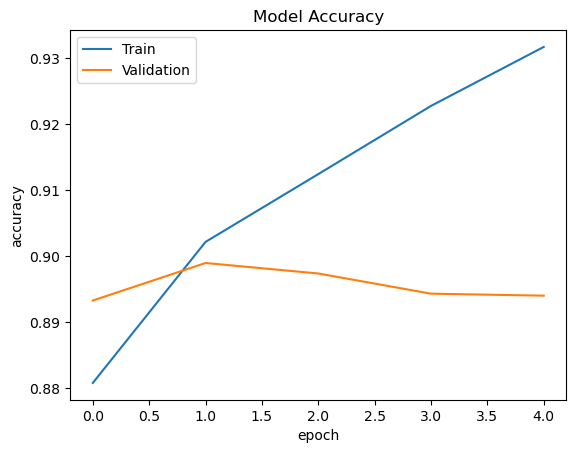

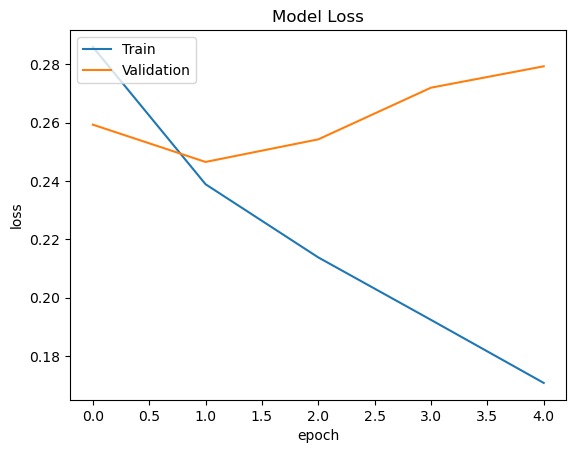

In [32]:
plt.plot(train_hist.history['Accuracy'])
plt.plot(train_hist.history['val_Accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(train_hist.history['loss'])
plt.plot(train_hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

As we can see, the model has underfiiting issues. So the model might not perform well on unseen data.

**Testing on test data**

In [39]:
test['processed Reviews'] = test['text'].apply(lambda x: text_cleaner(x))
tokenized_test_seq = tokenizer.texts_to_sequences(test['processed Reviews'])
X_test = pad_sequences(tokenized_test_seq, maxlen=60)
y_test = test['sentiment']

Now, we can make predictions on test data

In [40]:
predictions = model.predict(X_test)

63/63 [==============================] - 28s 73ms/step


In [41]:
binary_predictions = (predictions > 0.5).astype(int)

In [42]:
binary_predictions

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

**Evaluating the model**

In [37]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [43]:
print("Classification report: ", classification_report(y_test, binary_predictions))

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Classification report:                precision    recall  f1-score   support

           0       0.85      0.80      0.83       640
           1       0.91      0.93      0.92      1360

    accuracy                           0.89      2000
   macro avg       0.88      0.87      0.87      2000
weighted avg       0.89      0.89      0.89      2000



In [44]:
print("Confusion matrix: ", confusion_matrix(y_test, binary_predictions))

C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Confusion matrix:  [[ 512  128]
 [  89 1271]]
